# Clustering

In [1]:
# Install additional libraries
#!pip install fastcluster

# Import Libraries

In [2]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# Load Data

In [3]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [4]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

print('train:',X_train.shape)
print('validation:',X_validation.shape)
print('test:',X_test.shape)

train: (50000, 784)
validation: (10000, 784)
test: (10000, 784)


In [5]:
np.bincount(y_train)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988],
      dtype=int64)

In [6]:
print(sum(np.bincount(y_train)))

50000


# Dimensionality Reduction

In [7]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784

pca = PCA(n_components=n_components)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.461484,-1.246856,0.046275,-2.151944,-0.247284,-0.925426,0.889320,0.507180,-1.541690,0.689370,...,0.000000e+00,-0.000000e+00,-0.000000e+00,0.0,0.0,0.0,0.0,1.771838e-05,-0.000000,-0.000000e+00
1,3.921805,-1.252039,2.335258,-1.340842,-3.421519,-0.725720,-0.206354,-0.345258,0.134078,0.595468,...,-6.446579e-09,-2.937223e-10,3.775351e-09,0.0,0.0,0.0,0.0,-5.210083e-07,0.000001,1.413926e-06
2,-0.203586,1.547886,-0.980333,2.039061,-1.079858,0.112944,-3.312401,1.403132,-0.592806,-0.763858,...,-5.027801e-09,-3.219811e-09,2.081663e-09,0.0,0.0,0.0,0.0,1.955425e-07,-0.000007,7.058005e-07
3,-3.148331,-2.296074,1.091138,0.484675,0.066836,2.778989,-1.834335,-0.174753,1.166447,0.052853,...,-2.229050e-09,7.138817e-09,1.518124e-09,0.0,0.0,0.0,0.0,3.495156e-07,-0.000004,-5.303130e-07
4,-1.442694,2.872064,0.175669,-0.976944,0.302754,0.120619,-0.376697,-1.478133,1.003720,0.540805,...,-2.639406e-09,6.034794e-09,4.223676e-09,0.0,0.0,0.0,0.0,-1.470204e-07,0.000009,-3.305324e-07


In [8]:
#  # Log data
# cwd = os.getcwd()
# log_dir = cwd+"/logs/05_clustering/"
# y_train[0:2000].to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [9]:
# # Write dimensions to CSV
# X_train_PCA.iloc[0:2000,0:3].to_csv(log_dir+'pca_data.tsv', sep = '\t', index=False, header=False)

# K-means

## Inertia
- Cluster數量從2到20個, 觀察k-means inertia
- 只取前cutoff個PCA特徵,進行k-means 並將得到的inertia存於DataFrame

In [66]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans


n_init = 10 
max_iter = 300
tol = 0.0001
random_state = 2022

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])


In [67]:
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

<Axes: >

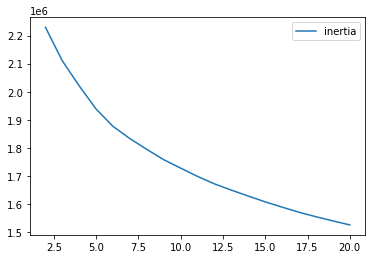

In [68]:
# Plot inertia relative to k # of clusters
kMeans_inertia.plot()

## Accuracy
### 如何設計分群好壞的評分指標

  
   單群精確度: 每一群內的同質性愈高, 表示分群的愈好. 同質性=該群內類別出現最多次的數量/該群的總數
   若值為1, 表示該群內為均為同一種類別, 若為0.5 表示只有一半是相同類別.
   
   整體的精確度=sum(各群內類別出現最多次的數量)/全部資料數

群的數量是為k (k=2~20)

- countByCluster:記錄了預測k群, 各群的數量分佈
- countMostFreq : 記錄預測的每一群中, 出現最多次數字的數量
- accuracyDF :為countMostFreq和countByCluster的合併
- countByLabel 記錄了Ground Truth在各群(即數字0~9)的數量分佈
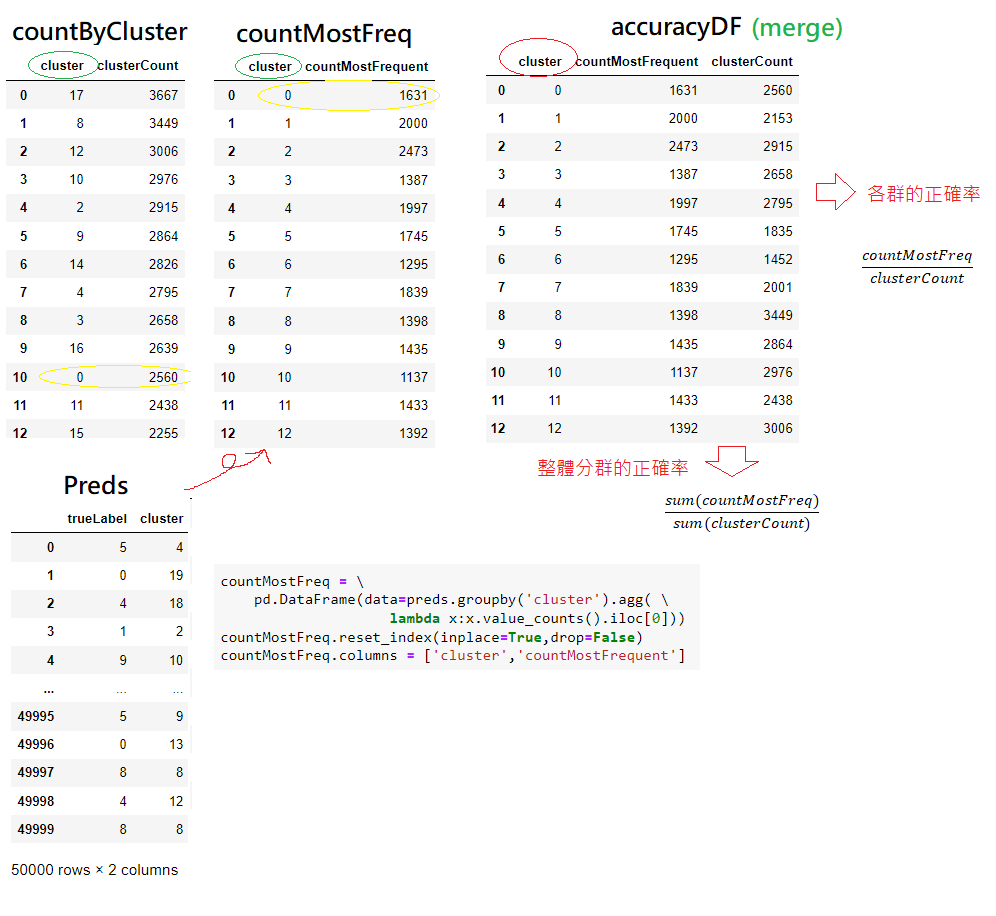

In [13]:
# Define analyze cluster function
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False) #drop＝False :ｔhe old index is added as a column in the DataFrame
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1) #merge  horizontally
    preds.columns = ['trueLabel','cluster']
    
      
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

### Review: Pandas  functoin

DataFrame.agg(func=None, axis=0, *args, **kwargs) <br>
Aggregate using one or more operations over the specified axis.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html

In [71]:
XClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
XClustered = pd.DataFrame(data=XClustered, index=X_train.index,columns=['cluster'])
XClustered_tbl = pd.concat([y_train,XClustered], axis=1)
XClustered_tbl.columns = ['trueLabel','cluster']
XClustered_tbl

,trueLabel,cluster
0,5,17
1,0,16
2,4,0
3,1,12
4,9,8
...,...,...
49995,5,14
49996,0,18
49997,8,11
49998,4,19


In [82]:
countByLabel = pd.DataFrame(data=XClustered_tbl.groupby('trueLabel').count())
countByLabel

,cluster
trueLabel,
0,4932
1,5678
2,4968
3,5101
4,4859
5,4506
6,4951
7,5175
8,4842


In [83]:
np.bincount(y_train)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988],
      dtype=int64)

In [78]:
#分群後每一群的數量
countByCluster = pd.DataFrame(XClustered_tbl['cluster'].value_counts())
countByCluster.reset_index(inplace=True,drop=False) #drop＝False :ｔhe old index is added as a column in the DataFrame
countByCluster.columns = ['cluster','clusterCount']
countByCluster

,cluster,clusterCount
0,10,3668
1,11,3480
2,19,3089
3,8,2936
4,12,2918
5,14,2893
6,9,2839
7,17,2804
8,1,2683
9,6,2588


In [73]:
#groupby 'cluster', 顯示每一群的label
XClustered_tbl.groupby('cluster').agg(lambda x: print(x))


2        4
20       4
60       4
158      7
164      4
        ..
49934    4
49942    4
49958    7
49967    4
49994    4
Name: trueLabel, Length: 2390, dtype: int64
9        4
11       5
24       1
29       7
35       5
        ..
49713    0
49745    4
49790    2
49792    2
49842    5
Name: trueLabel, Length: 2683, dtype: int64
25       2
76       2
117      2
122      2
143      2
        ..
49917    2
49962    2
49975    2
49976    2
49993    2
Name: trueLabel, Length: 2254, dtype: int64
54       9
89       4
115      4
139      4
167      9
        ..
49874    4
49904    9
49940    4
49982    4
49988    9
Name: trueLabel, Length: 2350, dtype: int64
15       7
19       9
22       9
33       9
71       7
        ..
49758    7
49793    9
49799    7
49854    9
49862    7
Name: trueLabel, Length: 2377, dtype: int64
69       0
75       0
80       9
81       0
95       0
        ..
49949    0
49952    0
49954    0
49974    0
49989    0
Name: trueLabel, Length: 1444, dtype: int64
17       8

,trueLabel
cluster,
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None


In [74]:
#groupby 'cluster', 計算每一群的label數量(預設由大小到小排序輸出) 
XClustered_tbl.groupby('cluster').agg(lambda x: print(x.value_counts()))

4    1082
9     780
7     255
2      73
5      71
8      44
6      43
3      22
0      20
Name: trueLabel, dtype: int64
5    1406
4     292
8     254
0     176
2     173
6     166
3      99
7      50
9      41
1      26
Name: trueLabel, dtype: int64
2    2127
3      49
6      21
1      20
8      17
7      13
0       3
5       2
9       1
4       1
Name: trueLabel, dtype: int64
4    1394
9     785
7      66
8      50
5      44
3       4
2       3
0       2
6       2
Name: trueLabel, dtype: int64
7    1486
9     609
4     190
8      44
2      24
3      14
5       7
1       3
Name: trueLabel, dtype: int64
0    1293
5      44
6      43
2      32
8      16
9       7
3       7
7       2
Name: trueLabel, dtype: int64
8    2061
5     197
3     173
2      93
0      32
7      10
1       7
9       7
6       5
4       3
Name: trueLabel, dtype: int64
6    1961
0      34
4      32
2      28
5      20
8      16
3      10
9       4
1       3
7       3
Name: trueLabel, dtype: int64
9    1106
7    1063


,trueLabel
cluster,
0,None
1,None
2,None
3,None
4,None
5,None
6,None
7,None
8,None


In [75]:
#取出各分群的出現最多次數的那一個label (即第0列的值)
countMostFreq=pd.DataFrame(XClustered_tbl.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
countMostFreq.reset_index(inplace=True,drop=False)
countMostFreq.columns = ['cluster','countMostFrequent']
countMostFreq

,cluster,countMostFrequent
0,0,1082
1,1,1406
2,2,2127
3,3,1394
4,4,1486
5,5,1293
6,6,2061
7,7,1961
8,8,1106
9,9,2495


In [79]:
accuracyDF = countMostFreq.merge(countByCluster,left_on="cluster",right_on="cluster")
accuracyDF

,cluster,countMostFrequent,clusterCount
0,0,1082,2390
1,1,1406,2683
2,2,2127,2254
3,3,1394,2350
4,4,1486,2377
5,5,1293,1444
6,6,2061,2588
7,7,1961,2111
8,8,1106,2936
9,9,2495,2839


In [81]:
#各群的正確率
accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
accuracyByLabel

0     0.452720
1     0.524040
2     0.943656
3     0.593191
4     0.625158
5     0.895429
6     0.796368
7     0.928944
8     0.376703
9     0.878831
10    0.843239
11    0.404598
12    0.847841
13    0.951762
14    0.500173
15    0.920881
16    0.933459
17    0.711840
18    0.956347
19    0.460019
dtype: float64

In [80]:
overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
print('overallAccuracy',overallAccuracy)

overallAccuracy 0.69994


## K-means - Accuracy as the number of clusters varies

In [19]:


n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<Axes: >

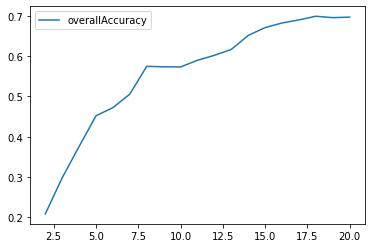

In [20]:
# Plot accuracy
#分群愈多,accuracy愈高(理所當然. 因為群愈多,群內的同質性就會愈高)
overallAccuracy_kMeansDF.plot()


In [21]:
# Accuracy by cluster
accuracyByLabel_kMeans

0     0.634156
1     0.923767
2     0.389366
3     0.905002
4     0.463787
5     0.941964
6     0.928007
7     0.856261
8     0.954465
9     0.596520
10    0.823661
11    0.711253
12    0.526414
13    0.950378
14    0.489108
15    0.838684
16    0.802189
17    0.385685
18    0.451670
19    0.864761
dtype: float64

In [22]:
# View cluster labels
X_train_kmeansClustered

,cluster
0,11
1,6
2,18
3,10
4,17
...,...
49995,14
49996,8
49997,2
49998,4


In [23]:
# Save cluster labels
X_train_kmeansClustered[0:2000].to_csv('kmeans_cluster_labels.tsv', sep = '\t', index=False, header=False)

## Accuracy as the number of principal components varies

In [85]:
# K-means - Accuracy as the number of components varies

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

In [86]:
kMeans_inertia

,inertia
9,503233.9375
49,1293282.25
99,1526205.5
199,1661288.375
299,1713286.75
399,1738081.375
499,1747047.375
599,1748294.875
699,1748408.375
783,1748408.5


<Axes: >

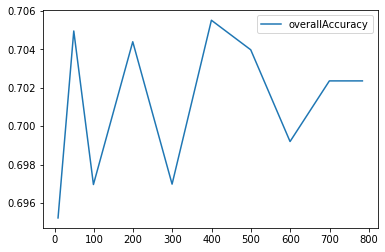

In [87]:
# Accuracy relative to number of principal components
overallAccuracy_kMeansDF.plot()

## Accuracy as the number of original dimensions varies

In [88]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\Users\joseph\anaconda3\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


<Axes: >

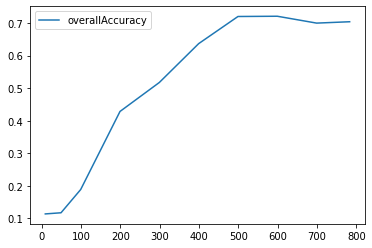

In [89]:
# Accuracy relative to number of original dimensions
overallAccuracy_kMeansDF.plot()

## Conculsion: 
使用原始資料，資料維度在784維時的正確率是0.7左右, 而若使用PCA時,在少於100個維度的情況下, 就可以達到0.7的正確率。

# Hierarchical clustering
https://jbhender.github.io/Stats506/F18/GP/Group10.html

**Ward’s method** says that the distance between two clusters, A and B, is how much the sum of squares will increase when we merge them.

$$ \Delta(A,B) = \sum_{i\in A \bigcup B} ||\overrightarrow{x_i} - \overrightarrow{m}_{A \bigcup B}||^2 - \sum_{i \in A}||\overrightarrow{x_i} - \overrightarrow{m}_A||^2 -\sum_{i \in B}||\overrightarrow{x_i}- \overrightarrow{m}_B||^2 
= \frac{n_An_B}{n_A+n_B} ||\overrightarrow{m}_A- \overrightarrow{m}_B||^2$$ 
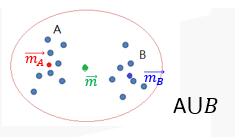

In [28]:
# Perform hierarchical clustering
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [29]:
# Show leaves
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562811,2.0
1,28350.0,37674.0,0.590923,2.0
2,26696.0,44705.0,0.621491,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637646,2.0
5,20465.0,24483.0,0.662483,2.0
6,466.0,42098.0,0.664151,2.0
7,46542.0,49961.0,0.665527,2.0
8,2301.0,5732.0,0.671081,2.0
9,37564.0,47668.0,0.675107,2.0


In [30]:
# Show leaves higher on the tree
Z_dataFrame.iloc[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99938.0,99959.0,152.158499,3544.0
49981,99953.0,99974.0,177.594230,5680.0
49982,99961.0,99976.0,179.132302,3379.0
49983,99942.0,99972.0,180.320587,4781.0
49984,99962.0,99980.0,189.535103,6051.0
49985,99971.0,99979.0,198.547538,6364.0
49986,99968.0,99969.0,202.903316,4246.0
49987,99954.0,99973.0,205.242622,6070.0
49988,99956.0,99982.0,222.401645,4872.0
49989,99966.0,99987.0,246.573179,9119.0


In [31]:
# Create clusters
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [32]:
# Print number of clusters
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  19


In [33]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.79216


In [34]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.917068
1     0.505117
2     0.503444
3     0.559322
4     0.969558
5     0.990623
6     0.986610
7     0.982719
8     0.860870
9     0.984424
10    0.960112
11    0.526806
12    0.402222
13    0.906386
14    0.952848
15    0.946633
16    0.982934
17    0.965486
18    0.701881
dtype: float64

In [35]:
# View cluster labels
X_train_hierClustered

,cluster
0,14
1,7
2,3
3,10
4,4
...,...
49995,14
49996,7
49997,12
49998,4


In [36]:
# Save cluster labels
X_train_hierClustered[0:2000].to_csv('hierarchical_cluster_labels.tsv', sep = '\t', index=False, header=False)

# DBSCAN

In [37]:
# Perform DBSCAN
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = \
    pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.22434

In [38]:
# Print overall accuracy
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.22434


In [39]:
# View cluster labels
X_train_PCA_dbscanClustered

,cluster
0,-1
1,-1
2,-1
3,0
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [40]:
# Show cluster results
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,42073
1,0,7259
2,5,184
3,1,100
4,4,66
5,11,36
6,12,31
7,16,29
8,3,21
9,13,21


In [41]:
accuracyDF_dbscan

,cluster,countMostFrequent,clusterCount
0,-1,5095,42073
1,0,5455,7259
2,1,100,100
3,2,14,14
4,3,21,21
5,4,65,66
6,5,184,184
7,6,9,9
8,7,9,9
9,8,10,10


In [42]:
# Save cluster labels
X_train_PCA_dbscanClustered[0:2000].to_csv('dbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

## Conclusion:
 DBSCAN 在處理MNIST 資料集表現比k-means差很多, 因為找不到 Density 的關係, 超過80%以上資料都被歸類成outlier. 扣除群0其他群僅僅是零星數量。

## Conslusion
 
 HDBSCAN 效果只有比 DBSCAN 好一點而己